In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

[]


In [2]:
train_dir = '/home/jetcalz07/state_farm_distracted_driver/data/imgs/train/'
test_dir = '/home/jetcalz07/state_farm_distracted_driver/data/imgs/test/'

### Set Params

In [3]:
# Image loading
img_rows = 128
img_cols = 128
color_type = 3

# Training
batch_size = 32
epochs = 20
unfreeze_layers = 10

### Load Data

In [4]:
# Function to read indiv image
def get_cv2_image(path, img_rows, img_cols, color_type=1):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.equalizeHist(img)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Histogram Equalize each image
        colorimage_b = cv2.equalizeHist(img[:,:,0])
        colorimage_g = cv2.equalizeHist(img[:,:,1])
        colorimage_r = cv2.equalizeHist(img[:,:,2])
        # Next we stack our equalized channels back into a single image
        img = np.stack((colorimage_b,colorimage_g,colorimage_r), axis=2)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

In [5]:
num_classes = 10
classes = ['c' + str(x) for x in range(num_classes)]

# Load train batch into image and label arrays
def load_train(img_rows, img_cols, color_type=1):
    train_imgs = []
    train_labels = []
    
    # Go through each folder
    i = 0
    for class_ in classes:
        files = glob(os.path.join(train_dir, class_, '*.jpg'))
        for file in tqdm(files):
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_imgs.append(img)
            train_labels.append(i)
        i += 1
            
    return train_imgs, train_labels


# Split into train and val
def normalize_and_split_train_val(img_rows, img_cols, color_type=1):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Convert dtype and reshape for batches
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_val = np.array(x_val, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_val, y_train, y_val
    
    
# Same for test
def load_test(img_rows, img_cols, color_type=1, size=200000):
    test_data = []
    test_files = []
    
    files = glob(os.path.join(test_dir, '*.jpg'))
    total = 0
    for file in tqdm(files):
        if total >= size:
            break
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        test_data.append(img)
        test_files.append(file)
        total += 1
            
    return test_data, test_files

def read_and_normalize_test_data(img_rows, img_cols, color_type=1, size=200000):
    test_data, test_files = load_test(img_rows, img_cols, color_type, size)
    test_data = np.array(test_data, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_files

100%|██████████████████████████████████████| 2129/2129 [00:16<00:00, 132.22it/s]


X Train shape: (17939, 128, 128, 3)
Y Train shape: (17939, 10)
X Val shape: (4485, 128, 128, 3)
Y Val shape: (4485, 10)

Sample Image Label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


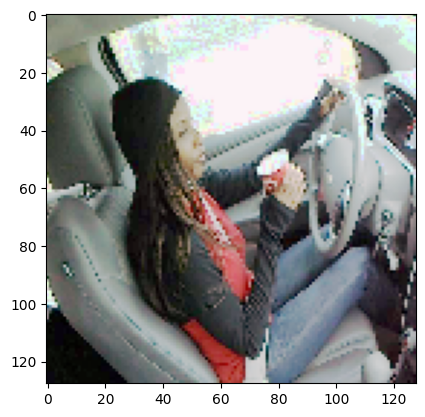

In [6]:
x_train, x_val, y_train, y_val = normalize_and_split_train_val(img_rows, img_cols, color_type)
print('X Train shape:', x_train.shape)
print('Y Train shape:', y_train.shape)
print('X Val shape:', x_val.shape)
print('Y Val shape:', y_val.shape)

print(f"\nSample Image Label: {y_train[0]}")
plt.imshow(x_train[0], cmap='gray')

### Model Functions

In [7]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('model accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('model loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')

    plt.show()

In [8]:
## Handle Submission
def evaluate_test(model, img_rows, img_cols, color_type, nb_test_samples):
    # Load test data
    x_test, test_files = read_and_normalize_test_data(img_rows, img_cols, color_type, nb_test_samples)
    print('Test shape:', x_test.shape)

    # Create batches to avoid GPU OOM on large test set
    batch_size = 32
    steps = x_test.shape[0] // batch_size
    print(f"# of steps in test: {steps+1}")

    # Predict and save df
    preds_df = pd.DataFrame()
    for step in tqdm(range(steps)):
        if step < (steps-1):
            x_test_batch = x_test[batch_size*step:batch_size*(step+1)]
            test_files_batch = test_files[batch_size*step:batch_size*(step+1)]
        else:
            x_test_batch = x_test[batch_size*step:]
            test_files_batch = test_files[batch_size*step:]
        preds = model.predict_on_batch(x_test_batch)

        # Create df and append to master df
        sub_df = pd.DataFrame(preds)
        sub_df.columns = [f'c{x}' for x in range(10)]
        sub_df['img'] = [os.path.basename(x) for x in test_files_batch]
        cols = sub_df.columns.to_list()
        sub_df = sub_df[cols[-1:] + cols[0:-1]]
        
        preds_df = pd.concat([preds_df, sub_df], axis = 0)
    print(f"Shape Preds: {preds_df.shape}")
        
    return preds_df

### Transfer Learn w/ ResNet50

In [9]:
x_train.shape

(17939, 128, 128, 3)

In [10]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   rotation_range=20,
                                   horizontal_flip = False,
                                   zca_whitening=False)
training_generator = train_datagen.flow(x_train_trim, y_train_trim, batch_size=batch_size)

val_datagen = ImageDataGenerator(rescale=1.0/ 255)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

NameError: name 'x_train_trim' is not defined

In [ ]:
# load model without output layer
new_input = Input(shape=(x_train.shape[1], x_train.shape[2], color_type))

resnet = Sequential()
pretrained_model= ResNet50(include_top=False,
                             input_shape=(x_train.shape[1],x_train.shape[2],color_type),
                             classes=num_classes,
                             weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False
for layer in pretrained_model.layers[-unfreeze_layers:]:
        layer.trainable=True
resnet.add(pretrained_model)
resnet.add(Flatten())
resnet.add(Dense(512, activation='relu'))
resnet.add(Dense(num_classes, activation='softmax'))

resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet.summary()

In [ ]:
history = resnet.fit_generator(training_generator,
                                 steps_per_epoch = x_train.shape[0] // batch_size,
                                 epochs = epochs, 
                                 verbose = 1,
                                 validation_data = val_generator,
                                 validation_steps = x_val.shape[0] // batch_size)

In [ ]:
plot_history(history)

### Evaluate and Submit

In [ ]:
try:
    del x_train, x_val, y_train, y_val
except:
    pass

## Evaluate test, save
nb_test_samples = len(os.listdir(test_dir))
preds_df = evaluate_test(resnet, img_rows, img_cols, color_type, nb_test_samples)
preds_df.to_csv('./test_preds/preds_resnet.csv', index=False)
preds_df.head()

In [ ]:
# Submit to kaggle thru CLI
!kaggle competitions submit -c state-farm-distracted-driver-detection -f ./test_preds/preds_resnet.csv -m "resnet_submission"